# Exercise 8: Classification Pipeline

**Libaries needed: pandas, sklearn>=0.19, numpy, nltk, graphviz (python-graphviz), e.g.**
```
conda install graphviz
conda install python-graphviz
```

First, make sure your environment is setup with the right libraries. In this exercise, you should be filling the empty code sections, marked as `TODO:`

In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Analyzing Weather Sentiments in Tweets

In this exercise, we consider the [Weather sentiment](https://data.world/crowdflower/weather-sentiment) dataset from [Crowdflower](https://www.crowdflower.com/).

To create this dataset, contributors were asked to grade the sentiment of a particular tweet relating to the weather. Contributors could choose among the following categories:
1. Positive
2. Negative
3. I can't tell
4. Neutral / author is just sharing information
5. Tweet not related to weather condition

The catch is that 20 contributors graded each tweet. Thus, in many cases contributors assigned conflicting sentiment labels to the same tweet. 

In the `data` directory, you will find the file [weather-non-agg-DFE.csv](data/weather-non-agg-DFE.csv) containing the raw contributor answers for each of the 1,000 tweets.


The fields of the csv file are as follows:
1. **_unit\_id_**: CrowdFlower’s numeric ID for the unit,
2. **channel**: channel via which the contributor entered the job,
3. **trust**: the contributor's accuracy level in the current job, determined by their accuracy on the Test Questions they’ve seen in the job,
4. **worker_id**: CrowdFlower Contributor ID,
5. **country**: worker's country code
6. **region**: worker's region
7. **city**: worker's city
8. **emotion**: worker's assigned emotion to the tweet
9. **tweet_id**: id of the tweet
10. **tweet_body**: body text of the tweet


Our goal in this exercise is to build a classifier that predicts the tweet's emotion according to the aforementioned categories. Towards that, we will be first aggregating the results of the crowdflower task in order to get a clean dataset. Then we will be preparing the data features by tokenizing the text. Finally, we will be inputting these features into a text classifier. 


### Task 1: Data Formatting

To begin with let's load the data into a format we can work with.



In [33]:
data = pd.read_csv('data/weather-non-agg-DFE.csv')
# print the shape of our data frame
print(data.shape)
data.head()

(20000, 10)


,_unit_id_,channel,trust,worker_id,country,region,city,emotion,tweet_id,tweet_body
0,314960382,clixsense,0.4541,18034918,IND,7,Delhi,Neutral / author is just sharing information,82846118,Fire Weather Watch issued May 17 at 4:21PM CDT...
1,314960385,clixsense,0.4541,18034918,IND,7,Delhi,Positive,82510997,Passing out now. working tonight. Storms toda...
2,314960391,clixsense,0.4541,18034918,IND,7,Delhi,Negative,83271279,"RT @mention: ""The storm is only that which aut..."
3,314960396,clixsense,0.4541,18034918,IND,7,Delhi,Positive,80058872,It is hot out here but it feels great
4,314960400,clixsense,0.4541,18034918,IND,7,Delhi,Neutral / author is just sharing information,80058809,I can't find a way to delete my iWitness Weath...


Let's see how our labels are distributed:

In [34]:
print("For all tweets:\n" + str(data.emotion.value_counts()))
print("For tweet_id=82846118:\n" + str(data[data.tweet_id==82846118].emotion.value_counts()))

For all tweets:
Neutral / author is just sharing information    5371
Negative                                        4986
Positive                                        4953
Tweet not related to weather condition          3553
I can't tell                                    1137
Name: emotion, dtype: int64
For tweet_id=82846118:
Neutral / author is just sharing information    16
I can't tell                                     1
Negative                                         1
Positive                                         1
Tweet not related to weather condition           1
Name: emotion, dtype: int64


### Task 2: Aggregating the Annotations

Now we will be aggregating the data of the workers to obtain one label per tweet. Your input is the pandas data frame `data`. Your output should be a data frame of 1000 rows, with one `emotion` field for each `tweet_id`. You should use the Majority Decision algorithm, where the value of `emotion` field is simply the one occurring most frequently per `tweet_id`.




In [36]:
# We're only interested in these columns for now ['tweet_id','emotion', 'tweet_body'].
# We convert the data to an object with just these columns 
data= data[['tweet_id','emotion', 'tweet_body']]

# TODO: Aggregate with Majority weighted algorithm
agg_data = data.groupby(data.tweet_id).agg({
    'emotion': lambda group: group.value_counts().index[0], # value counts all possible values in decreasing order
    'tweet_body': lambda group: list(group)[0] # take the first message of each group (should all be the same)
})

By now, your data should have been aggregated. You should get 1000 rows in total as we had 20 labels. The index column for your data frame would be the `tweet_id`. Let's get a preview of how the data frame looks like now.

In [37]:
# We can verify the shape of the resulting data (should be (1000,2))
print('data shape:',agg_data.shape)
# We can also check the columns and the index
print('data columns:',agg_data.columns)
print('data columns:',agg_data.index.name)
agg_data.head()

data shape: (1000, 2)
data columns: Index(['tweet_body', 'emotion'], dtype='object')
data columns: tweet_id


,tweet_body,emotion
tweet_id,,
79185673,I dunno which asshole in the sky flunked out o...,Negative
79185724,"@mention Seriously, that's February weather!",Neutral / author is just sharing information
79185900,Special Weather Statement issued May 05 at 5:1...,Neutral / author is just sharing information
79186190,@mention TC: loved the new Fresh Air (#16). Cu...,Positive
79186569,@mention HAPPY BIRTHDAY!!! You're planning on ...,Positive


We will split now the dataset into two parts, the training data and the testing data. The test data should be 0.2 of the original data size. 

In [109]:
from sklearn.model_selection import train_test_split

# TODO: fill here
train_data, test_data = train_test_split(agg_data, test_size=0.2, random_state= 42)

In [110]:
# check a sample of the training data
train_data.head()

,tweet_body,emotion
tweet_id,,
79189697,Mad windy for no reason,Negative
82838312,#WEATHER: 1:56 pm : 77.0F. Feels F. 29.96% Hu...,Neutral / author is just sharing information
83257061,I should've went to Colombia for the month at ...,Positive
82840644,Follow @mention @mention @mention #Glee #Herec...,Tweet not related to weather condition
84050466,it's hot as #Truck outside,Negative


In [111]:
# check a sample of the test data
test_data.head()

,tweet_body,emotion
tweet_id,,
82837308,We got hot chocolate here at the Ridgeland bas...,Negative
83269180,@mention I had sonic too! I got orange slush t...,Tweet not related to weather condition
83269499,Waiting patiently for the electric car. Glorio...,Positive
82853149,Memphis weather is so bipolar!!!,Negative
82517760,Argh. WHY does the guy behind me have his AC b...,Negative


You can see the number of samples from each class.

In [112]:
print('training') 
print(train_data.emotion.value_counts().sum())
print('testing')
print(test_data.emotion.value_counts().sum())

training
800
testing
200


### Task 3: Feature Creation

Now that we have aggregated the data, we will work on creating the features to use in our classifier. The input to the classifier is a tweet. However, for this task, we will be using the tokens (e.g., words) in the tweet as the feautres.
In specific, each tweet will be represented with a vector that indicates what words are in the tweet and how frequently each word occurs. This way, we do not account for the order of occurrence of these words. This kind of features is also called the **bag of words** technique.

Let's further process and take a look first on our data:

In [113]:
x_train = train_data['tweet_body'].values
y_train = train_data['emotion'].values
x_test = test_data['tweet_body'].values
y_test = test_data['emotion'].values

print(list(zip(x_train, y_train)))

[('Mad windy for no reason', 'Negative'), ('#WEATHER:  1:56 pm : 77.0F. Feels F. 29.96% Humidity. 11.5MPH South Wind.', 'Neutral / author is just sharing information'), ("I should've went to Colombia for the month at least they have beautiful weather", 'Positive'), ('Follow @mention @mention @mention #Glee #Herecomestheboom #sunshine @mention!!', 'Tweet not related to weather condition'), ("it's hot  as #Truck outside", 'Negative'), ('Heavy Dust Storm Blankets Parts Of Chandler: A good sized dust storm blew through the east valley blanketing par... {link}', 'Neutral / author is just sharing information'), ('@mention rrrrriiight who yu tellin idk weather to be mad or cry -__-', 'Negative'), ('Needless to say, it is scorching out. I am still hot and I have been back inside for quite some time now.', 'Negative'), ('Waking up to beautiful weather- what a great day it will be!', 'Positive'), ('We brought the sunshine from LA... But we also brought the traffic! #SMUGGLERSTOUR {link}', 'Posit

In [164]:
class_names

['Neutral / author is just sharing information',
 'Positive',
 'Negative',
 'Tweet not related to weather condition',
 "I can't tell"]

Now let's see how we can transform our tweets into vectors

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

#Convert a collection of text documents to a matrix of token counts
count_vect = CountVectorizer()
# we take two samples
samples = x_train[:2]
# TODO: fit and transform these samples to get the count vectors
x_train_counts = count_vect.fit_transform(samples)

# You can see how these vectors look with the following commands
print(pd.DataFrame(x_train_counts.A, columns=count_vect.get_feature_names()).to_string())

   0f  11  29  56  5mph  77  96  feels  for  humidity  mad  no  pm  reason  south  weather  wind  windy
0   0   0   0   0     0   0   0      0    1         0    1   1   0       1      0        0     0      1
1   1   1   1   1     1   1   1      1    0         1    0   0   1       0      1        1     1      0


### Task 4: Creating the Classifiers

In practice, it's cleaner to integrate all of our preprocessing and classifier into a single [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). So let's do that now. Add the missing code to build a simple pipeline with CountVectorizer and a Multinomial Naive Bayes classifier.

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


def build_pipeline(classifier_fn,x_train,y_train):
    # max_df : max document frequency of word
    # min_n <= n <= max_n
    count_vect = CountVectorizer(ngram_range=(1, 2),max_df=0.5)
    
    pipeline = Pipeline([
        ('count_vectorizer', count_vect), 
        ('classifier', classifier_fn)])
    pipeline.fit(x_train,y_train)
    return pipeline

pipeline = build_pipeline(MultinomialNB(),x_train,y_train)

In [116]:
class_names = data['emotion'].unique().tolist()
class_names

['Neutral / author is just sharing information',
 'Positive',
 'Negative',
 'Tweet not related to weather condition',
 "I can't tell"]

To evaluate the classifiers, we will be using the precision, recall, and F1 scores. 

                                              precision    recall  f1-score   support

Neutral / author is just sharing information       0.90      0.64      0.75        56
                                    Positive       0.58      0.75      0.66        53
                                    Negative       0.57      0.63      0.60        46
      Tweet not related to weather condition       0.57      0.51      0.54        45
                                I can't tell       0.00      0.00      0.00         0

                                   micro avg       0.64      0.64      0.64       200
                                   macro avg       0.52      0.51      0.51       200
                                weighted avg       0.67      0.64      0.64       200



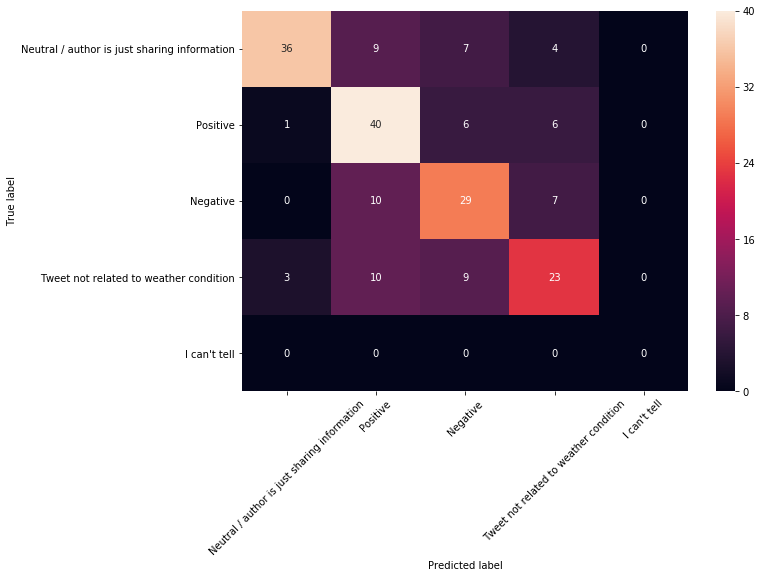

In [165]:
from sklearn.metrics import precision_recall_fscore_support,classification_report, confusion_matrix

# TODO: get the class names from the data
class_names = data['emotion'].unique().tolist()

def plot_confusion_matrix(y_test,y_predicted,labels):
    cm = confusion_matrix(y_test, y_predicted,labels =labels)

    figsize = (10,7)
    df_cm = pd.DataFrame(
        cm, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return
    
def evaluate_classifier(pipeline, x_test, y_test):
    # get the predictions
    y_predicted = pipeline.predict(x_test)
    # generate the report
    # Build a text report showing the main classification metrics
    report = classification_report(y_test, y_predicted, labels=class_names)
    print(report)
    # plot the confusion matrix
    plot_confusion_matrix(y_test, y_predicted, class_names)
    # Get scores
    # support : The number of occurrences of each label in y_true.
    # same as classification report
#     precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_predicted, labels=class_names)
    
    return

evaluate_classifier(pipeline, x_test,y_test)

We can experiment with other classifiers as we please at this point. Try using an SVM classifier and a RandomForestClassifier classifier instead. You might notice that the Multinomial Naive Bayes is already a good baseline for short text classification.


                                              precision    recall  f1-score   support

Neutral / author is just sharing information       0.75      0.70      0.72        56
                                    Positive       0.75      0.57      0.65        53
                                    Negative       0.44      0.61      0.51        46
      Tweet not related to weather condition       0.60      0.60      0.60        45
                                I can't tell       0.00      0.00      0.00         0

                                   micro avg       0.62      0.62      0.62       200
                                   macro avg       0.51      0.49      0.50       200
                                weighted avg       0.65      0.62      0.63       200



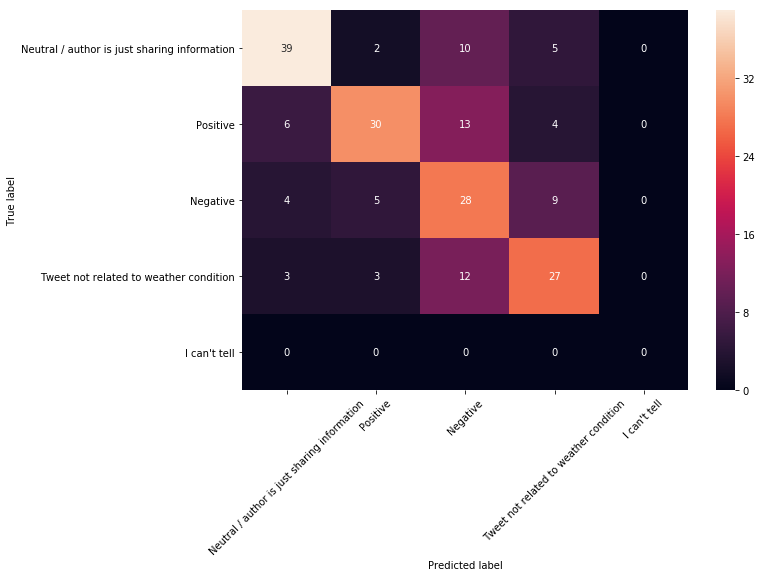

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# TODO: build the pipeline with an SGDClassifier (SVM) and evaluate it
svm_pipeline = build_pipeline(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None), x_train,y_train)
evaluate_classifier(svm_pipeline, x_test,y_test)

                                              precision    recall  f1-score   support

Neutral / author is just sharing information       0.86      0.64      0.73        56
                                    Positive       0.73      0.45      0.56        53
                                    Negative       0.47      0.89      0.62        46
      Tweet not related to weather condition       0.68      0.58      0.63        45
                                I can't tell       0.00      0.00      0.00         0

                                   micro avg       0.64      0.64      0.64       200
                                   macro avg       0.55      0.51      0.51       200
                                weighted avg       0.70      0.64      0.64       200



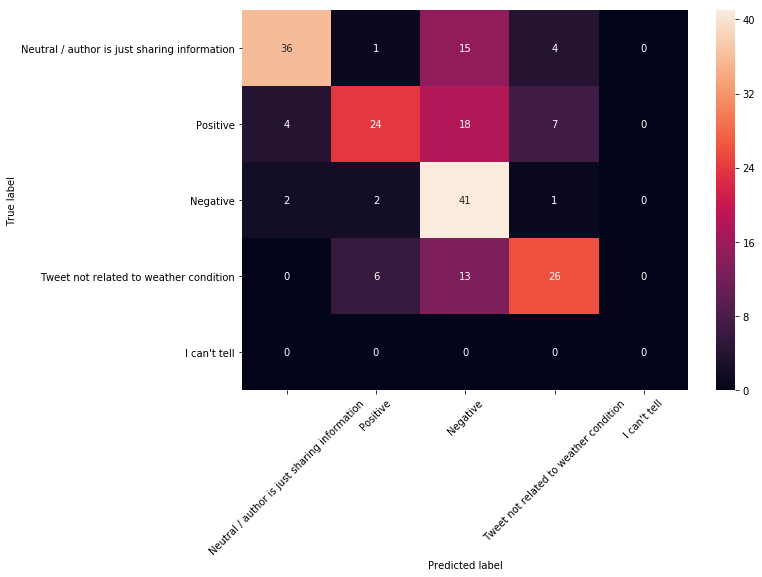

In [119]:
# TODO: build the pipeline with a Random Forest Classifier and evaluate it
rf_pipeline = build_pipeline(RandomForestClassifier(n_estimators=500), x_train,y_train)
evaluate_classifier(rf_pipeline, x_test,y_test)

### Task 5: Predicting Emotions for New Tweets

It's worth noting that as have the classifiers, we can try them a couple of new tweets.

In [120]:
tweets = ["love the weather","#WEATHER: 7:51 am E: 55.0F. Feels F. 30.01% Humidity. 3.5MPH Variable Wind."]
# TODO: get the predictions
predictions = [svm_pipeline.predict(tweets), pipeline.predict(tweets), rf_pipeline.predict(tweets)]
predictions

[array(['Positive', 'Neutral / author is just sharing information'],
       dtype='<U44'),
 array(['Positive', 'Neutral / author is just sharing information'],
       dtype='<U44'),
 array(['Positive', 'Neutral / author is just sharing information'],
       dtype=object)]

### Task 6: Visualizing a Decision Tree Classifier

side note: this requires the installation of **graphviz**

One way to see how our features are affecting the classification is to use interpretable classifiers like Decision Trees. To begin with, let's add another step to our pipeline, where we use TF-IDF measure for each word as a vector element instead of taking the term frequency only. We'll use the [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [121]:
from sklearn.feature_extraction.text import TfidfTransformer
#TfidfTransformer: Transform a count matrix to a normalized tf or tf-idf representation

# TODO: build a new pipeline with the TfidfTransformer
def build_tfid_pipeline(classifier_fn,x_train,y_train):
    count_vect = CountVectorizer(ngram_range=(1, 2),max_df=0.5)
    pipeline = Pipeline([
        ('count_vectorizer', count_vect),
        ('tfidtransformer', TfidfTransformer()),
        ('classifier', classifier_fn)
        ])
    pipeline.fit(x_train,y_train)
    return pipeline

Now we're ready to build and visualize the decision tree.

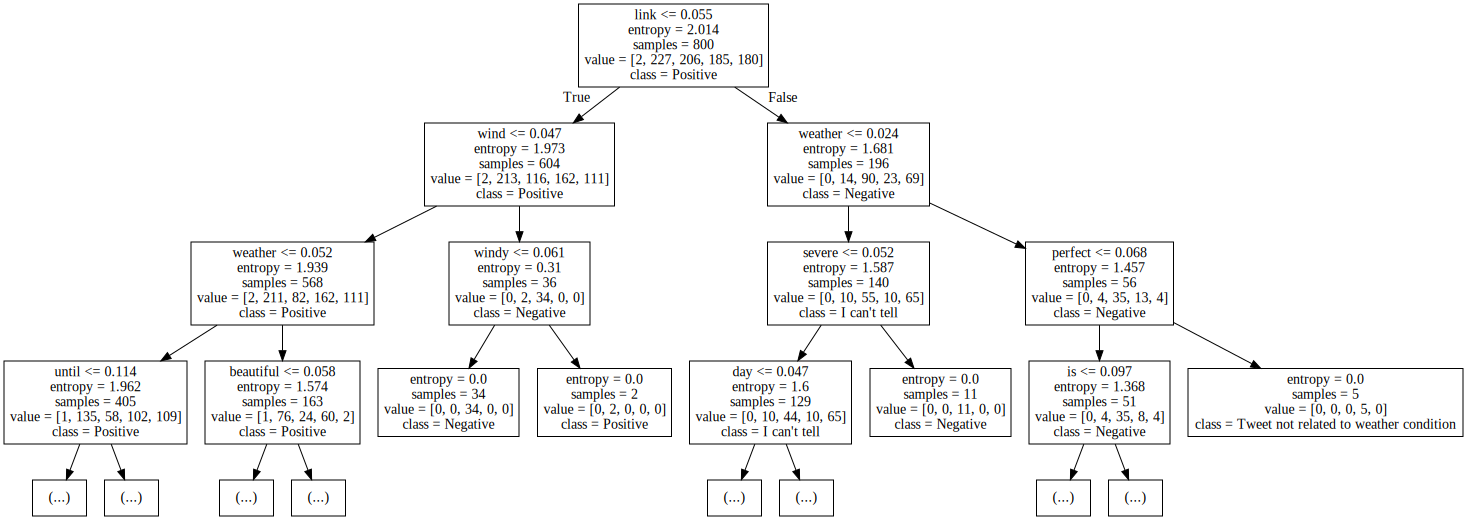

In [152]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# TODO: build the pipeline with the Decision Tree Classifier
pipeline = build_tfid_pipeline(DecisionTreeClassifier(criterion="entropy"), x_train, y_train)
# extract the classifier and the count_vectorizer from the pipeline
classifier= pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
# TODO: Use export_graphviz to visualize the classifiers. You already have all the needed parameters.
# max_depth: The maximum depth of the representation
dot_data = export_graphviz(classifier, out_file=None, max_depth=3, 
                          feature_names=count_vectorizer.get_feature_names(), class_names=class_names)

graph = graphviz.Source(dot_data) 
graph

### Task 7 Get Feature Importance

One way to debug our classifiers and see how they are working is to investigate the features and print the most important ones. We'll do that next. But to start, let's do one more preprocessing step that further removes some of the noise: removing stop words.

In [123]:
from nltk.corpus import stopwords

# remove stopwords in order to improve interpretability
stop = stopwords.words('english')
stop += ['rt','@mention:','@mention','link']

# TODO: write a function that removes the stop words from each string in a numpy array of strings 
def remove_stopwords(x_train):
    cleaned_x_train = []
    for phrase in x_train:
        words = phrase.split()
        resultwords  = [word for word in words if word.lower() not in stop]
        result = ' '.join(resultwords)
        cleaned_x_train.append(result)
    
    return np.array(cleaned_x_train)


x_train_nostop = remove_stopwords(x_train)
x_test_no_stop = remove_stopwords(x_test)

print(x_train_nostop)

['Mad windy reason'
 '#WEATHER: 1:56 pm : 77.0F. Feels F. 29.96% Humidity. 11.5MPH South Wind.'
 'went Colombia month least beautiful weather'
 'Follow #Glee #Herecomestheboom #sunshine @mention!!'
 'hot #Truck outside'
 'Heavy Dust Storm Blankets Parts Chandler: good sized dust storm blew east valley blanketing par... {link}'
 'rrrrriiight yu tellin idk weather mad cry -__-'
 'Needless say, scorching out. still hot back inside quite time now.'
 'Waking beautiful weather- great day be!'
 'brought sunshine LA... also brought traffic! #SMUGGLERSTOUR {link}'
 'nothing better woman warm weather #yeahiamthattype'
 'Tatum, NM @ 12:00 PM: Temp:90F(H 91/L 55), Hum: 3&#x25;, DewPt:-1F, Wind: WSW 18 G 28.0 mph, Rain:0.00 In. #weather'
 'BREAKING: Large, wedge tornado ground coming Okla City LIVE weather blog {link} ...'
 'Thx - sounds like gone crazy weather...'
 'Gardner WX 05/18/11 03:00 | 49F, 55&#x25; Humidity, Feels Like 49F | Alerts: CURRENT ADVISORIES | {link}'
 '#WEATHER: 2:53 pm : 57.0F

Now we're ready to get the most important features for each class. Complete the function below with the missing lines. An easy sanity check is to see if the words that are important for the "Positive" class are actually positive and vice-versa!

In [135]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=20):
    labelid = list(classifier.classes_).index(classlabel)
    print("Labelid: {}".format(labelid))
    # TODO: get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    print("Classlabel \t Feature \t\t Coefficient")
    for coef, feat in topn:
        print(classlabel, '\t', feat, '\t\t', coef)

        
pipeline = build_pipeline(MultinomialNB(),x_train_nostop,y_train)
# TODO: get the most informative features for a Multinomial NB classifier 
# by using the function above for the classes "Positive" and "Negative"
classifier = pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
most_informative_feature_for_class(count_vectorizer,classifier,"Positive")

Labelid: 3
Classlabel 	 Feature 		 Coefficient
Positive 	 like 		 -7.08631978689838
Positive 	 morning 		 -7.08631978689838
Positive 	 storm 		 -7.08631978689838
Positive 	 warm 		 -7.08631978689838
Positive 	 weekend 		 -7.08631978689838
Positive 	 nice weather 		 -6.991009607094055
Positive 	 rain 		 -6.991009607094055
Positive 	 love 		 -6.823955522430889
Positive 	 good 		 -6.749847550277167
Positive 	 perfect 		 -6.749847550277167
Positive 	 today 		 -6.749847550277167
Positive 	 outside 		 -6.680854678790215
Positive 	 degrees 		 -6.616316157652644
Positive 	 beautiful 		 -6.344382442169003
Positive 	 nice 		 -6.29786242653411
Positive 	 day 		 -6.253410663963276
Positive 	 link 		 -6.21085104954448
Positive 	 sunshine 		 -5.892397318425946
Positive 	 sunny 		 -5.725343233762779
Positive 	 weather 		 -4.982185632628172


In [133]:
most_informative_feature_for_class(count_vectorizer, classifier, "Negative")

Labelid: 1
Classlabel 	 Feature 		 Coefficient
Negative 	 sunny 		 -7.125524413958892
Negative 	 go 		 -7.030214234154567
Negative 	 lol 		 -7.030214234154567
Negative 	 windy 		 -7.030214234154567
Negative 	 damn 		 -6.943202857164938
Negative 	 today 		 -6.943202857164938
Negative 	 back 		 -6.863160149491401
Negative 	 bad 		 -6.863160149491401
Negative 	 day 		 -6.789052177337679
Negative 	 rain 		 -6.789052177337679
Negative 	 degrees 		 -6.720059305850727
Negative 	 rainy 		 -6.720059305850727
Negative 	 link 		 -6.594896162896721
Negative 	 cold 		 -6.483670527786497
Negative 	 like 		 -6.483670527786497
Negative 	 freezing 		 -6.292615291023788
Negative 	 storm 		 -6.292615291023788
Negative 	 outside 		 -6.095904996777733
Negative 	 hot 		 -5.994122302467791
Negative 	 weather 		 -4.9282998366226725


In [134]:
most_informative_feature_for_class(count_vectorizer, classifier, "Neutral / author is just sharing information")

Labelid: 2
Classlabel 	 Feature 		 Coefficient
Neutral / author is just sharing information 	 thunderstorms 		 -6.931772241233379
Neutral / author is just sharing information 	 thunderstorm warning 		 -6.857664269079656
Neutral / author is just sharing information 	 rain 		 -6.724132876455133
Neutral / author is just sharing information 	 feels 29 		 -6.663508254638699
Neutral / author is just sharing information 	 severe thunderstorm 		 -6.663508254638699
Neutral / author is just sharing information 	 warning 		 -6.663508254638699
Neutral / author is just sharing information 	 thunderstorm 		 -6.552282619528475
Neutral / author is just sharing information 	 00 		 -6.5009893251409245
Neutral / author is just sharing information 	 may 		 -6.5009893251409245
Neutral / author is just sharing information 	 severe 		 -6.31866776834697
Neutral / author is just sharing information 	 29 		 -6.238625060673433
Neutral / author is just sharing information 	 0f 		 -6.12942576870844
Neutral / autho

### Task 8: Cross validation

Above, we were using a training set and a testing set for evaluating our models. A more robust way to evaluate a model is to use cross validation. In the code below, we will do such evaluation. At the same time, we will use the cross-validation results to select better parameters for our model. More specifically, we will find a good `alpha` parameter for the `MultinomialNB` model. Hence, we will plot the variation of the F1 score for the "Positive" and the "Negative" labels.

In [160]:
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold


# construct a new X and y 
X = np.concatenate((x_train_nostop, x_test_no_stop),axis=0)
y = np.concatenate((y_train, y_test),axis=0)  

# prepare for the cross validation 
kf = StratifiedKFold(n_splits=5,random_state=4)

alphas = [(i*0.1) for i in range(0,10)]
# Naive bayes: smoothing parameter (0 for no smoothing)

total_f1_pos = []
total_f1_neg = []

for a in alphas:
    f_score_pos = []
    f_score_neg = []
    for train_index, test_index in kf.split(X,y):
        print(train_index, test_index)
        # TODO: build the pipeline for the current alpha and the current training and testing set 
        pipeline = build_pipeline(MultinomialNB(alpha=a) ,X[train_index], y[train_index])
       
        y_predicted = pipeline.predict(X[test_index])
        report  = precision_recall_fscore_support(y[test_index], y_predicted)
        print(report)
        
        # let's get the f1_score value for the "Positive" and the "Negative" labels to plot them
        
        ind_pos = list(pipeline.classes_).index('Positive')
        ind_neg = list(pipeline.classes_).index('Negative')

        # report 0 is precision
        # report 2 is f-score
        fscore_positive = report[0][ind_pos]
        fscore_negative = report[0][ind_neg]
        
        f_score_pos += [fscore_positive]
        f_score_neg += [fscore_negative]
                
    # TODO: extend the arrays with the average  fscore_positive and fscore_negative repsectively.
    total_f1_pos += [np.mean(f_score_pos)]
    total_f1_neg += [np.mean(f_score_neg)]
    


[184 187 189 192 200 203 204 205 208 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 44

(array([0.45333333, 0.82857143, 0.50793651, 0.51851852]), array([0.61818182, 0.55769231, 0.66666667, 0.31111111]), array([0.52307692, 0.66666667, 0.57657658, 0.38888889]), array([55, 52, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


[184 187 189 192 200 203 204 205 208 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 44

(array([0.        , 0.51724138, 0.75      , 0.47058824, 0.6       ]), array([0.        , 0.54545455, 0.56603774, 0.66666667, 0.46666667]), array([0.        , 0.53097345, 0.64516129, 0.55172414, 0.525     ]), array([ 1, 55, 53, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 

(array([0.51851852, 0.69230769, 0.48529412, 0.625     ]), array([0.51851852, 0.69230769, 0.70212766, 0.33333333]), array([0.51851852, 0.69230769, 0.57391304, 0.43478261]), array([54, 52, 47, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


(array([0.        , 0.52459016, 0.75      , 0.49230769, 0.61111111]), array([0.        , 0.58181818, 0.56603774, 0.66666667, 0.48888889]), array([0.        , 0.55172414, 0.64516129, 0.56637168, 0.54320988]), array([ 1, 55, 53, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 

(array([0.51851852, 0.69230769, 0.49253731, 0.64      ]), array([0.51851852, 0.69230769, 0.70212766, 0.35555556]), array([0.51851852, 0.69230769, 0.57894737, 0.45714286]), array([54, 52, 47, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


(array([0.        , 0.52542373, 0.725     , 0.49253731, 0.61111111]), array([0.        , 0.56363636, 0.54716981, 0.6875    , 0.48888889]), array([0.        , 0.54385965, 0.62365591, 0.57391304, 0.54320988]), array([ 1, 55, 53, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 

(array([0.55882353, 0.825     , 0.56896552, 0.71875   ]), array([0.7037037 , 0.63461538, 0.70212766, 0.51111111]), array([0.62295082, 0.7173913 , 0.62857143, 0.5974026 ]), array([54, 52, 47, 45]))
[184 187 189 192 200 203 204 205 208 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399


(array([0.53947368, 0.84375   , 0.58730159, 0.5862069 ]), array([0.74545455, 0.51923077, 0.77083333, 0.37777778]), array([0.6259542 , 0.64285714, 0.66666667, 0.45945946]), array([55, 52, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


(array([0.        , 0.54285714, 0.80851064, 0.59649123, 0.82142857]), array([0.        , 0.69090909, 0.71698113, 0.70833333, 0.51111111]), array([0.        , 0.608     , 0.76      , 0.64761905, 0.63013699]), array([ 1, 55, 53, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 185 186 188 190 

(array([0.53703704, 0.69811321, 0.52307692, 0.61538462]), array([0.53703704, 0.71153846, 0.72340426, 0.35555556]), array([0.53703704, 0.7047619 , 0.60714286, 0.45070423]), array([54, 52, 47, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 185 186 188 190 191 193 194 195 196 197 198 199 201 202
 206 207 209 340 359 361 362 365 372 377 378 380 381 382 384 386 389 396
 398 399 402 405 407 409 413 415 422 423 424 425 427 428 429 430 433 434
 435 436 437 438 439 440 441 442 443 444 445 446 44

(array([0.52830189, 0.69811321, 0.50746269, 0.64      ]), array([0.51851852, 0.71153846, 0.72340426, 0.35555556]), array([0.52336449, 0.7047619 , 0.59649123, 0.45714286]), array([54, 52, 47, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 185 186 188 190 191 193 194 195 196 197 198 199 201 202
 206 207 209 340 359 361 362 365 372 377 378 380 381 382 384 386 389 396
 398 399 402 405 407 409 413 415 422 423 424 425 427 428 429 430 433 434
 435 436 437 438 439 440 441 442 443 444 445 446 44

(array([0.51923077, 0.69811321, 0.51515152, 0.59259259]), array([0.5       , 0.71153846, 0.72340426, 0.35555556]), array([0.50943396, 0.7047619 , 0.60176991, 0.44444444]), array([54, 52, 47, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


(array([0.        , 0.53571429, 0.725     , 0.48529412, 0.60526316]), array([0.        , 0.54545455, 0.54716981, 0.6875    , 0.51111111]), array([0.        , 0.54054054, 0.62365591, 0.56896552, 0.55421687]), array([ 1, 55, 53, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 

(array([0.56060606, 0.84444444, 0.56896552, 0.75862069]), array([0.68518519, 0.73076923, 0.70212766, 0.48888889]), array([0.61666667, 0.78350515, 0.62857143, 0.59459459]), array([54, 52, 47, 45]))
[184 187 189 192 200 203 204 205 208 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399


(array([0.57534247, 0.81818182, 0.58064516, 0.59375   ]), array([0.76363636, 0.51923077, 0.75      , 0.42222222]), array([0.65625   , 0.63529412, 0.65454545, 0.49350649]), array([55, 52, 48, 45]))
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197


In [155]:
print(pipeline)

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True))])


We now plot the variation of the F1 score with different `alpha` values.

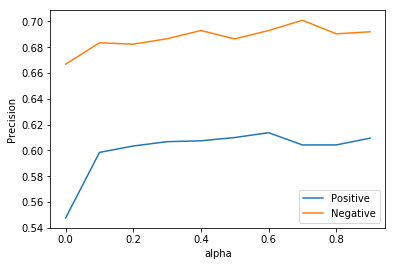

In [156]:
plt.plot(alphas,total_f1_pos,label='Positive')
plt.plot(alphas,total_f1_neg,label='Negative')

plt.xlabel('alpha')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [158]:
y

array(['Negative', 'Neutral / author is just sharing information',
       'Positive', 'Tweet not related to weather condition', 'Negative',
       'Neutral / author is just sharing information', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive',
       'Neutral / author is just sharing information',
       'Neutral / author is just sharing information', 'Negative',
       'Neutral / author is just sharing information',
       'Neutral / author is just sharing information', 'Negative',
       'Negative', 'Tweet not related to weather condition', 'Negative',
       'Negative', 'Neutral / author is just sharing information',
       'Tweet not related to weather condition', 'Positive',
       'Neutral / author is just sharing information',
       'Neutral / author is just sharing information', 'Negative',
       'Positive', 'Neutral / author is just sharing information',
       'Positive', 'Neutral / author is just sharing information',
       'Neutral / author is just shar

### Bonus Task 9: Food for thought

There is a lot of room for improvement in the above problem. Here are some issues to think about:
- You can see a lot of numbers and measures of wind speed or humidity in the dataset. Can we do some custom tokenization to group these similar features into a single one?
- Can we alternatively discretize these measures and turn them into discrete features like low/high wind speed? If people are expressing sentiment based on temperature, humdity, etc., this could be a good potential classifier which can work well in practice.
- You have seen that some of the labels have no predictions in the testing set. This is due to the imbalanced dataset. What can we do to improve this?